### Metrics-5b: Apply y_norm to FeatsNet fitting

In [73]:
import os, sys
import copy as copyroot
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
from fastai2.basics import *
from fastai2.vision.all import *
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
%load_ext autoreload
%autoreload 2

from module.mnist_helpers import build_df, eda_fig_1, build_dls
from module.mnist_models import FeatsNet
from module.mnist_metrics import metrics_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup

In [25]:
dls_dummy = build_dls(target='topleft')

point_t = dls_dummy.transform[1][1]
scale_t = dls_dummy.after_item
def my_scale(x): return scale_t(point_t(x))

path = untar_data(URLs.MNIST_TINY)
df = build_df(path)

y_cols =      ['point_topleft_x', 'point_topleft_y']
y_sc_cols =   ['point_topleft_x_sc', 'point_topleft_y_sc']
y_nm_cols =   ['point_topleft_x_nm', 'point_topleft_y_nm']

y_sc = pd.DataFrame(my_scale(df[y_cols]), columns = y_sc_cols)
df = pd.concat((df, y_sc), axis=1)

ss = StandardScaler()
ss.fit(df[y_sc_cols])
y_norm = pd.DataFrame(ss.transform(df[y_sc_cols]), columns = y_nm_cols)
df = pd.concat((df, y_norm), axis=1)

In [74]:
db =   DataBlock(blocks=(ImageBlock(cls=PILImageBW),
                         #PointBlock), 
                         RegressionBlock(n_out=2)),
                splitter=RandomSplitter(seed=0),
                get_x=ColReader('fn', pref=path),
                get_y=ColReader(y_nm_cols),)

dl = db.dataloaders(df)

In [110]:
b = dl.one_batch()
b[1].min(), b[1].max()

(tensor(-2.2131), tensor(2.2740))

### Plot Scaling

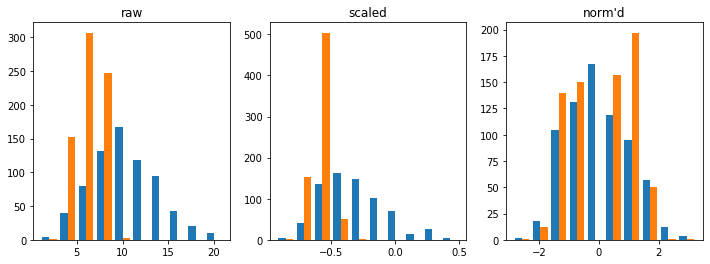

In [35]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].hist(df[y_cols].to_numpy())
ax[1].hist(df[y_sc_cols].to_numpy())
ax[2].hist(df[y_nm_cols].to_numpy())
ax[0].set_title("raw")
ax[1].set_title("scaled")
ax[2].set_title("norm'd");

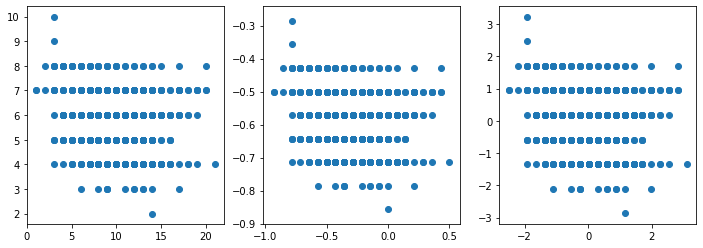

In [54]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].scatter(df[y_cols].iloc[:,0], df[y_cols].iloc[:,1])
ax[1].scatter(df[y_sc_cols].iloc[:,0], df[y_sc_cols].iloc[:,1])
ax[2].scatter(df[y_nm_cols].iloc[:,0], df[y_nm_cols].iloc[:,1]);

### Establishing `y_range`

#### `extremes` - edges of the picture based on normalize scaler, `ss`

In [111]:
nm_extremes = ss.transform([[-1, -1], [1,1]])
nm_extremes

array([[-2.77400092, -4.4006674 ],
       [ 5.07848247, 16.96969646]])

In [133]:
lo_extrmes, hi_extremes = nm_extremes.min(), nm_extremes.max()
lo_extrmes, hi_extremes

(-4.400667395419339, 16.969696455342376)

#### `samples` - lowest/highest points in training sample
Since they are generated from batches, they are already tranformed by normalizer

In [134]:
lo_samples = dl.tfms[1](df).min().item()
hi_samples = dl.tfms[1](df).max().item()
lo_samples, hi_samples

(-2.8742129802703857, 3.2316055297851562)

#### It does get reflected in pytorch model

In [135]:
fn = FeatsNet(feats=['pts12', 'pts22'], lo=lo, hi=hi)
fn

FeatsNet(
  (flat): Flatten()
  (linear1): Linear(in_features=64, out_features=28, bias=True)
  (linear2): Linear(in_features=28, out_features=2, bias=False)
  (sig): SigmoidRange(low=-4.400667395419339, high=16.969696455342376)
)

#### Look at the feed forward effect on the models
The scaling effect, why is this bad tho with normalization?

In [148]:
feats =      ['pts12', 'pts22']

fn_default =  FeatsNet(feats=feats, lo=-1., hi=1.)
fn_samples =  FeatsNet(feats=feats, lo=lo_samples, hi=hi_samples)
fn_extremes = FeatsNet(feats=feats, lo=lo_extrmes, hi=hi_extremes)

In [149]:
fn_default(b), fn_samples(b), fn_extremes(b)

(tensor([[-0.1610,  0.1431],
         [-0.1597,  0.1437]], grad_fn=<AddBackward0>),
 tensor([[ 0.0537, -0.2805],
         [ 0.0618, -0.2777]], grad_fn=<AddBackward0>),
 tensor([[8.0707, 8.3519],
         [8.0639, 8.3758]], grad_fn=<AddBackward0>))

### Fitting LR

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.033113110810518265)

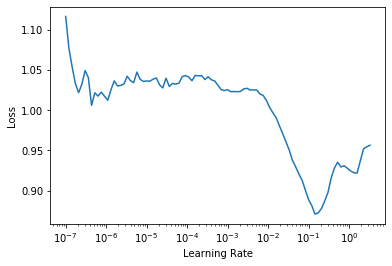

In [150]:
learn = Learner(dl, fn_default, loss_func=MSELossFlat())
learn.lr_find()

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.0691830962896347)

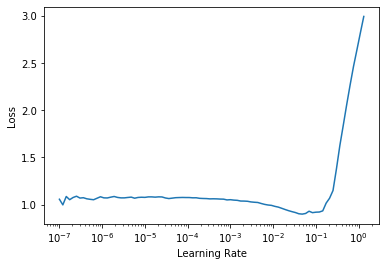

In [151]:
learn = Learner(dl, fn_samples, loss_func=MSELossFlat())
learn.lr_find()

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.0030199517495930195)

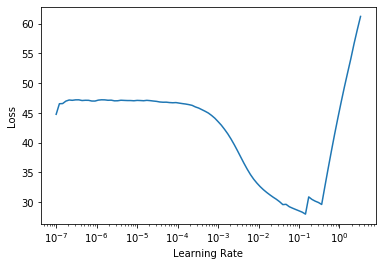

In [152]:
learn = Learner(dl, fn_extremes, loss_func=MSELossFlat())
learn.lr_find()

### Train a model, what is the y_range?

In [154]:
learn_default = Learner(dl, fn_default, loss_func=MSELossFlat())
with learn_default.no_logging(): learn_default.fit(20,lr=1e-2)

In [183]:
ss.scale_

array([0.2546965 , 0.09358755])

In [186]:
ss.transform([[-.5,-.5], [.5,.5]])

array([[-0.81088007,  0.94192357],
       [ 3.11536163, 11.62710549]])

#### This is directly feeding a batch into the Learner's \[trained] model

In [156]:
b = dl.one_batch()

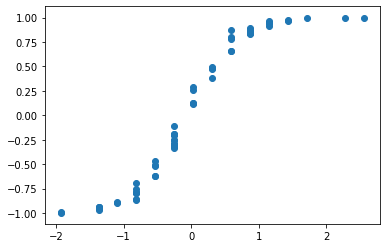

In [171]:
ind_coord = 0
pred =  learn_default.model(b[0])[:,ind_coord].detach()
actual =                     b[1][:,ind_coord].detach()

plt.scatter(actual, pred)

In [176]:
ind_coord = 0
preds  = learn_default.get_preds()
pred   = preds[0][:,ind_coord]
actual = preds[1][:,ind_coord]

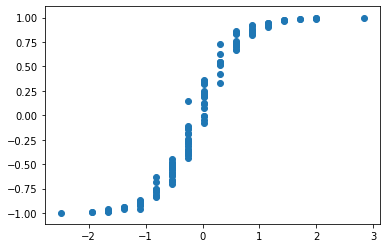

In [179]:
plt.scatter(actual, pred)

### Train second y_range model

In [188]:
learn_samples = Learner(dl, fn_samples, loss_func=MSELossFlat())
with learn_samples.no_logging(): learn_samples.fit(20,lr=1e-2)

In [189]:
b = dl.one_batch()

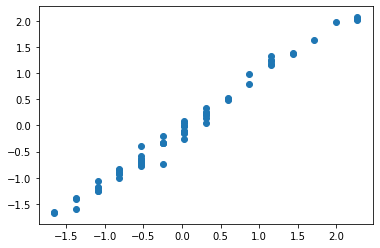

In [191]:
ind_coord = 0
pred =  learn_samples.model(b[0])[:,ind_coord].detach()
actual =                     b[1][:,ind_coord].detach()

plt.scatter(actual, pred)

In [192]:
ind_coord = 0
preds  = learn_samples.get_preds()
pred   = preds[0][:,ind_coord]
actual = preds[1][:,ind_coord]

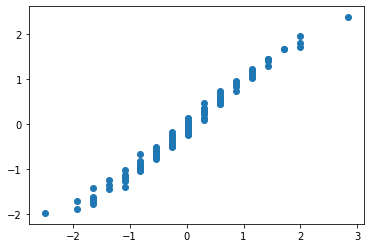

In [193]:
plt.scatter(actual, pred)

### Third y_range

In [194]:
learn_extremes = Learner(dl, fn_extremes, loss_func=MSELossFlat())
with learn_extremes.no_logging(): learn_extremes.fit(20,lr=1e-2)

In [195]:
ind_coord = 0
preds  = learn_extremes.get_preds()
pred   = preds[0][:,ind_coord]
actual = preds[1][:,ind_coord]

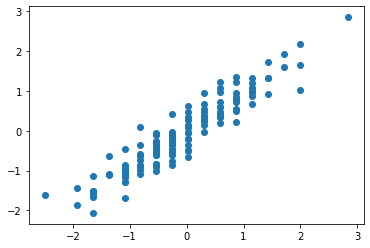

In [196]:
plt.scatter(actual, pred)

### Train For Real??

In [197]:
learn_samples = Learner(dl, fn_samples, loss_func=MSELossFlat())

In [198]:
learn_samples.fit(90,lr=1e-2)

epoch,train_loss,valid_loss,time
0,0.505176,0.129336,00:03
1,0.335594,0.119828,00:03
2,0.255302,0.086334,00:03
3,0.203791,0.057421,00:03
4,0.167757,0.053104,00:03
5,0.140762,0.039166,00:03
6,0.120004,0.034686,00:03
7,0.104024,0.033812,00:03
8,0.091026,0.030434,00:03
9,0.081252,0.030873,00:03


#### Analyze the PvA

In [199]:
preds = learn_samples.get_preds()

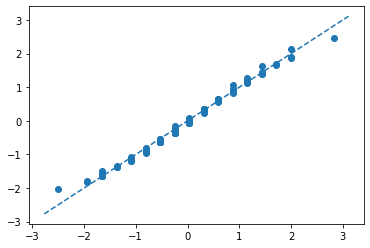

In [200]:
plt.scatter(preds[1].view(-1,2)[:,0], preds[0][:,0], )
tmp = torch.tensor((plt.xlim(), plt.ylim())).flatten()
lo, hi = tmp.min().item(), tmp.max().item()
plt.plot([lo,hi],[lo,hi], linestyle='--');

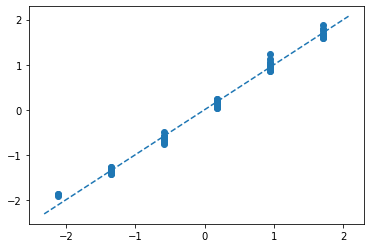

In [201]:
plt.scatter(preds[1].view(-1,2)[:,1], preds[0][:,1], )
tmp = torch.tensor((plt.xlim(), plt.ylim())).flatten()
lo, hi = tmp.min().item(), tmp.max().item()
plt.plot([lo,hi],[lo,hi], linestyle='--');

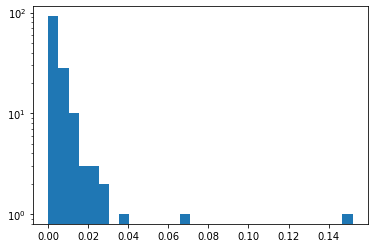

In [212]:
preds = learn_samples.get_preds(with_loss=True)

plt.hist(preds[2], bins=30, log=True );

#### Analyze the Metrics

In [202]:
mdf_sc = metrics_df(learn_samples, "","","", y_scaler=ss)
mdf_sc

,model,details,target,split,mse,mae,r2,dist_avg,dist_r2,sqdist_avg,sqdist_r2
0,,,,valid,0.000254,0.010208,0.992838,0.016679,0.922796,0.000508,0.992057
1,,,,train,0.000250,0.010116,0.993396,0.016791,0.928610,0.000499,0.993429


In [203]:
mdf_nosc = metrics_df(learn_samples, "","","")
mdf_nosc

,model,details,target,split,mse,mae,r2,dist_avg,dist_r2,sqdist_avg,sqdist_r2
0,,,,valid,0.006516,0.058608,0.992838,0.089841,0.926952,0.013031,0.992918
1,,,,train,0.006729,0.058027,0.993396,0.090995,0.929800,0.013459,0.993396


### Build Out Metrics and Save

In [205]:
mdf = metrics_df(learn_samples,
           s_model="FeatsNet3.1222",
           s_details="y_norm=True | feats=11,12 | epochs=90, lr=1e-2",
           s_target="topleft",
           y_scaler=ss,
          )
mdf

,model,details,target,split,mse,mae,r2,dist_avg,dist_r2,sqdist_avg,sqdist_r2
0,FeatsNet3.1222,"y_norm=True | feats=11,12 | epochs=90, lr=1e-2",topleft,valid,0.000254,0.010208,0.992838,0.016679,0.922796,0.000508,0.992057
1,FeatsNet3.1222,"y_norm=True | feats=11,12 | epochs=90, lr=1e-2",topleft,train,0.000250,0.010116,0.993396,0.016791,0.928610,0.000499,0.993429


In [206]:
mdf.to_csv('assets/metrics-dfs/metrics5b-feats3.csv', index=False)